In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline
import geopandas as gpd
import xarray as xr
import matplotlib.dates as mdates

# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, TIModel, BASENAMES, process_era5_daily_data

from oggm.utils import (floatyear_to_date, date_to_floatyear)

In [2]:
cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True

# this needs to be changed if working on another computer
working_dir = utils.gettempdir(dirname='W5E5_quality', reset=True)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')
# My configs
cfg.PARAMS['hydro_month_nh'] = 1
climate='W5E5'

2022-12-07 09:44:40: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-12-07 09:44:40: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-12-07 09:44:40: oggm.cfg: Multiprocessing: using all available processors (N=16)
2022-12-07 09:44:40: oggm.cfg: Multiprocessing switched ON after user settings.
2022-12-07 09:44:40: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.


In [3]:
fr = utils.get_rgi_region_file(14, version='62')
gdf = gpd.read_file(fr)

In [4]:
df = ['RGI60-14.12678']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version='62')
gdir = gdirs[0]
gdir

2022-12-07 09:44:43: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2022-12-07 09:44:43: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2022-12-07 09:44:43: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-14/RGI60-14.12.tar verified successfully.


<oggm.GlacierDirectory>
  RGI id: RGI60-14.12678
  Region: 14: South Asia West
  Subregion: 14-02: Karakoram                       
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 0.552 km2
  Lon, Lat: (77.552342005, 34.288076476)
  Grid (nx, ny): (60, 80)
  Grid (dx, dy): (20.0, -20.0)

In [5]:
# Get climate Data
process_w5e5_data(gdir, climate_type=climate, temporal_resol='daily', y0 = 2018, y1=2019)
file = gdir.get_filepath("climate_historical", filesuffix="_daily_W5E5")
ds = xr.open_dataset(file)
ds

2022-12-07 09:44:44: MBsandbox.mbmod_daily_oneflowline: (RGI60-14.12678) process_w5e5_data
2022-12-07 09:44:47: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_lapserates_monthly.nc verified successfully.


<xarray.Dataset>
Dimensions:   (time: 730)
Coordinates:
  * time      (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2019-12-31
Data variables:
    prcp      (time) float32 ...
    temp      (time) float32 ...
    tempmax   (time) float32 ...
    tempmin   (time) float32 ...
    hurs      (time) float32 ...
    rsds      (time) float32 ...
    gradient  (time) float32 ...
Attributes:
    ref_hgt:         4572.0
    ref_pix_lon:     77.75
    ref_pix_lat:     34.25
    ref_pix_dis:     18650.087280591542
    climate_source:  temp: W5E5_daily, prcp: W5E5_daily, lapse rate: ERA5dr
    hydro_yr_0:      2018
    hydro_yr_1:      2019
    author:          OGGM
    author_info:     Open Global Glacier Model

In [6]:
df = ds.sel(time='2019').to_dataframe()
aws_hgt = 4009
df1 = pd.read_csv(
            "/home/bsurya/work/air_model/data/gangles21/interim/field.csv",
            sep=",",
            parse_dates=["time"],
        )

# use strftime to turn a timestamp into a 
# a nicely formatted d-m-Y string:
df1["time"] = df1.time.map(lambda ts: ts.replace(year=2019))
df1 = df1.set_index("time")
df1 = df1.resample('D').mean()
df1['gradient'] = df['gradient']
df1['corr_temp'] = df1['temp'] + df1['gradient']  * (ds.ref_hgt - aws_hgt)

/tmp/ipykernel_24661/3636867445.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df1.resample('D').mean()


[]

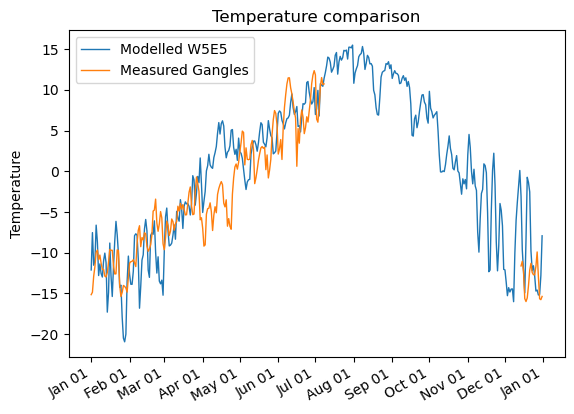

In [7]:
    fig, ax = plt.subplots()
#    x1 = df.time
#    x2 = df1.time
    y1 = df.temp
    y2 = df1.temp
    y3 = df1.corr_temp
    ax.set_ylabel("Temperature")
    ax.plot(
#        x1,
        y1,
        label="Modelled W5E5",
        linewidth=1
    )
    ax.plot(
#        x2,
        y3,
        label="Measured Gangles",
        linewidth=1
    )
    plt.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    fig.autofmt_xdate()
    plt.title('Temperature comparison')
    plt.savefig(
        "../figs/W5E5_Validation.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.plot()


In [8]:
df1.columns

Index(['Unnamed: 0', 'temp', 'RH', 'wind', 'press', 'SW_global', 'ppt',
       'gradient', 'corr_temp'],
      dtype='object')

[]

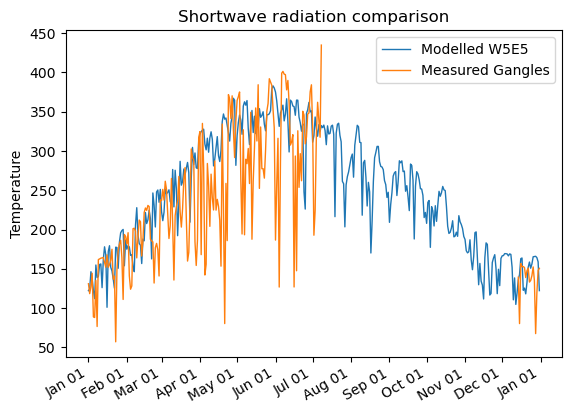

In [9]:
    fig, ax = plt.subplots()
#    x1 = df.time
#    x2 = df1.time
    y1 = df.rsds
    y2 = df1.SW_global
    y3 = df1.corr_temp
    ax.set_ylabel("Temperature")
    ax.plot(
#        x1,
        y1,
        label="Modelled W5E5",
        linewidth=1
    )
    ax.plot(
#        x2,
        y2,
        label="Measured Gangles",
        linewidth=1
    )
    plt.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    fig.autofmt_xdate()
    plt.title('Shortwave radiation comparison')
    plt.savefig(
        "../figs/W5E5_SW_Validation.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.plot()


[]

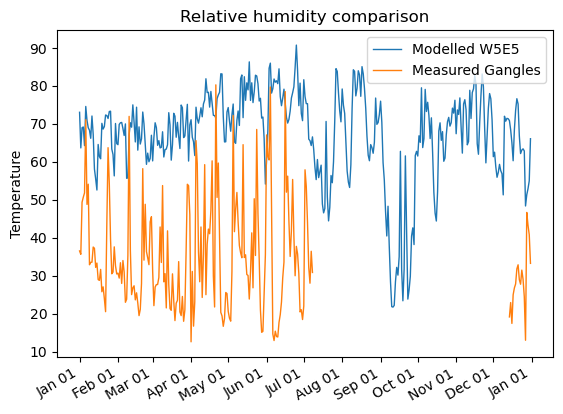

In [10]:
    fig, ax = plt.subplots()
#    x1 = df.time
#    x2 = df1.time
    y1 = df.hurs
    y2 = df1.RH
    y3 = df1.corr_temp
    ax.set_ylabel("Temperature")
    ax.plot(
#        x1,
        y1,
        label="Modelled W5E5",
        linewidth=1
    )
    ax.plot(
#        x2,
        y2,
        label="Measured Gangles",
        linewidth=1
    )
    plt.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    fig.autofmt_xdate()
    plt.title('Relative humidity comparison')
    plt.savefig(
        "../figs/W5E5_RH_Validation.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.plot()


[]

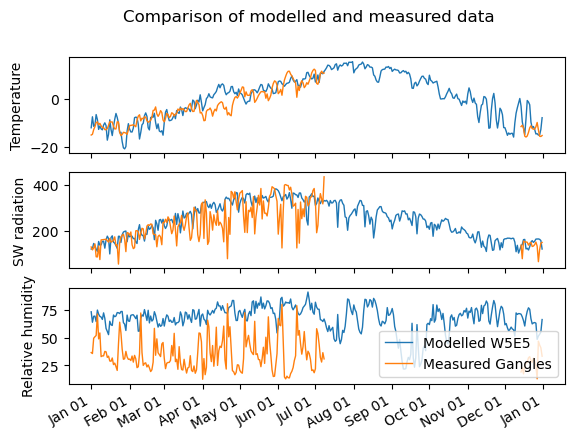

In [11]:
fig, axs = plt.subplots(3, sharex=True)
fig.suptitle('Comparison of modelled and measured data')
y01 = df.temp
y02 = df1.corr_temp
y11 = df.rsds
y12 = df1.SW_global
y21 = df.hurs
y22 = df1.RH

axs[0].set_ylabel("Temperature")
axs[0].plot(y01,
        label="Modelled W5E5",
        linewidth=1
       )
axs[0].plot(y02,
        label="Measured Gangles",
        linewidth=1
       )

axs[1].set_ylabel("SW radiation")
axs[1].plot(y11,
        label="Modelled W5E5",
        linewidth=1
       )
axs[1].plot(y12,
        label="Measured Gangles",
        linewidth=1
       )

axs[2].set_ylabel("Relative humidity")
axs[2].plot(y21,
        label="Modelled W5E5",
        linewidth=1
       )
axs[2].plot(y22,
        label="Measured Gangles",
        linewidth=1
       )

plt.legend()
axs[0].xaxis.set_major_locator(mdates.MonthLocator())
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate()
plt.savefig(
        "../figs/W5E5_Validation.png",
        bbox_inches="tight",
        dpi=300,
)
plt.plot()

In [12]:
df.to_csv('../output/w5e5_2019.csv')

<AxesSubplot: xlabel='time'>

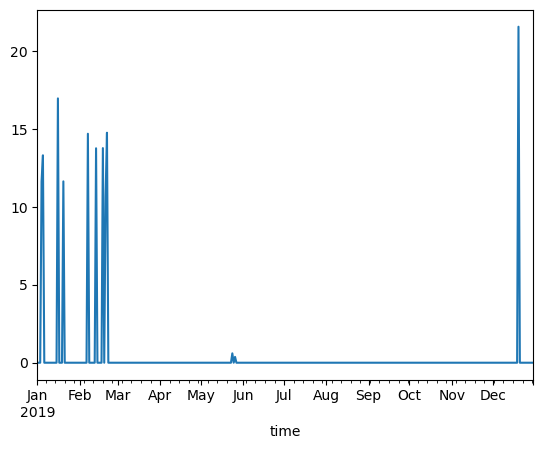

In [13]:
df.prcp.plot()